In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.dca_agent import DCAAgent
from agentfil import constants
from mechafil import minting, sim

import numpyro

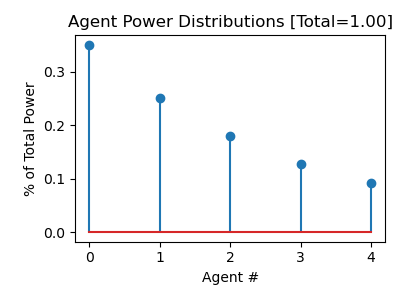

In [3]:
NDEVICES=2
numpyro.set_host_device_count(NDEVICES)

simulation_start_date = datetime.today().date() - timedelta(days=1)
forecast_length = 360
end_date = simulation_start_date + timedelta(days=forecast_length)

num_agents = 5
agent_power_distributions = distribute_agent_power_geometric_series(num_agents, a=0.35)
    
plt.figure(figsize=(4,3))

plt.stem(agent_power_distributions)
plt.xlabel('Agent #')
plt.ylabel('% of Total Power')
plt.title('Agent Power Distributions [Total=%0.02f]' % (np.sum(agent_power_distributions),))

plt.tight_layout()

In [4]:
agent_types = [DCAAgent] * num_agents
agent_kwargs_vec = []
random_seed_base=1000
rng = np.random.RandomState(random_seed_base)

mean_pow = 3
std_pow = 0.5
for ii in range(num_agents):
    kwargs = {
        'max_daily_onboard_qap_pib': rng.normal(mean_pow, std_pow),
        'sector_duration': 360
    }
    agent_kwargs_vec.append(kwargs)

minting_process_kwargs = {
    'forecast_history': 180,
    'update_every_days': 90,
    'num_warmup_mcmc': 500,
    'num_samples_mcmc': 500,
    'seasonality_mcmc': 1000,
    'num_chains_mcmc': 2,
    'verbose': False,
    'keep_previous_predictions': True,
    'keep_power_predictions': True,   # Setting this to true enables debugging plots but slows down simulation
}
price_process_kwargs = {
    'forecast_num_mc':1000,
    'random_seed':1234
}
capital_inflow_process_kwargs = {
    'debug_model': True
}

filecoin_model = FilecoinModel(num_agents, simulation_start_date, end_date, 
                               agent_types, agent_kwargs_vec, agent_power_distributions=agent_power_distributions,
                               compute_cs_from_networkdatastart=True, use_historical_gas=False,
                               price_process_kwargs=price_process_kwargs,
                               minting_process_kwargs=minting_process_kwargs,
                               capital_inflow_process_kwargs=capital_inflow_process_kwargs)

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Fast forwarding power to simulation start date... 2023-02-07
Computing Scheduled Expirations from:  2023-02-07  to:  2024-02-01
CV Scores - Model Fit [7.08247208e-01 9.15332302e-01 8.98810983e-01 2.40104595e-04
 6.85467449e-01] 0.6416196093141341


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [5]:
sim_len = (end_date - simulation_start_date).days
for ii in tqdm(range(sim_len)):
    filecoin_model.step()

  0%|          | 0/360 [00:00<?, ?it/s]

In [6]:
# agent plotting helper functions
def plot_agent(keys, post_process=None, agent_idxs_to_plot=None, df_name='agent_info_df',
               x_key='date', label_prepend='', label_postpend='', plot_kwargs_list=None):
    if post_process is None:
        post_fn = lambda x: x
    else:
        post_fn = post_process
    
    # defaults to plotting all agents
    for ii, agent_dict in enumerate(filecoin_model.agents):
        if agent_idxs_to_plot is None or ii in agent_idxs_to_plot:
            agent_handle = agent_dict['agent']
            agent_df = getattr(agent_handle, df_name)
            l = label_prepend + '-Agent%d' % (ii,) + '-' + label_postpend
            plot_kwargs = plot_kwargs_list[ii] if plot_kwargs_list is not None else {}
            if len(keys)==1:
                k = keys[0]
                y = post_fn(agent_df[k])
                plt.plot(agent_df[x_key], y, label=l, **plot_kwargs)
            else:
                # get all keys and call the combine function
                key_data = {}
                for k in keys:
                    key_data[k] = agent_df[k]
                y = post_fn(key_data)
                plt.plot(agent_df[x_key], y, label=l, **plot_kwargs)
            plt.xticks(rotation=60)

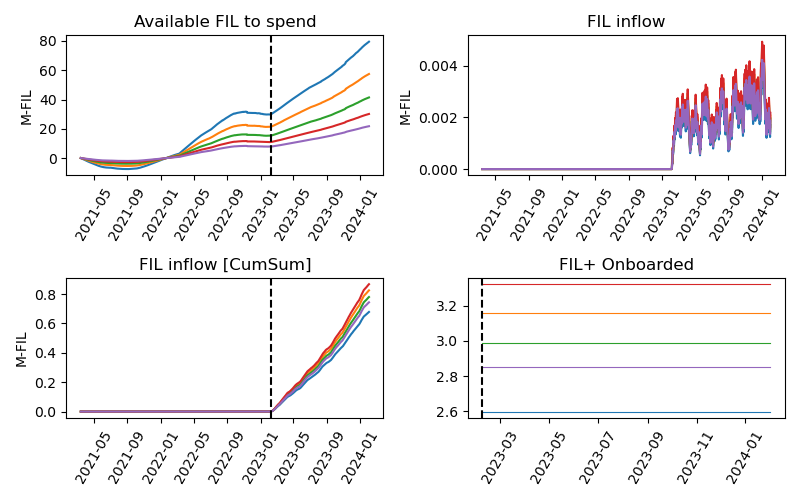

In [7]:
plt_kwargs = [{'linewidth': 0.8}] * num_agents

plt.figure(figsize=(8,5))

plt.subplot(2,2,1)
keys = ['reward_FIL', 
        'onboard_pledge_FIL', 
        'renew_pledge_FIL', 
        'onboard_scheduled_pledge_release_FIL', 
        'renew_scheduled_pledge_release_FIL',
        'capital_inflow_FIL']
def compute_available_fil_to_spend(key_data):
    available_FIL_to_spend = key_data['reward_FIL'].cumsum() \
                           - key_data['onboard_pledge_FIL'].cumsum() \
                           - key_data['renew_pledge_FIL'].cumsum() \
                           + key_data['onboard_scheduled_pledge_release_FIL'].cumsum() \
                           + key_data['renew_scheduled_pledge_release_FIL'].cumsum() \
                           + key_data['capital_inflow_FIL'].cumsum()
    return available_FIL_to_spend/1_000_000
plot_agent(keys, post_process=compute_available_fil_to_spend, df_name='accounting_df')
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.ylabel('M-FIL')
plt.title('Available FIL to spend')

plt.subplot(2,2,2)
post_process = lambda x: x/1_000_000
plot_agent(['capital_inflow_FIL'], post_process=post_process, df_name='accounting_df')
plt.title('FIL inflow')
plt.ylabel('M-FIL')

plt.subplot(2,2,3)
post_process = lambda x: x.cumsum()/1_000_000
plot_agent(['capital_inflow_FIL'], post_process=post_process, df_name='accounting_df')
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('FIL inflow [CumSum]')
plt.ylabel('M-FIL')

plt.subplot(2,2,4)
plot_agent(['deal_onboarded'], plot_kwargs_list=plt_kwargs)
plt.axvline(simulation_start_date, linestyle='--', color='k')
plt.title('FIL+ Onboarded')


plt.tight_layout()

In [8]:
model_df = filecoin_model.filecoin_df
model_df_simsubset = model_df[model_df['date'] >= pd.to_datetime(simulation_start_date)]

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


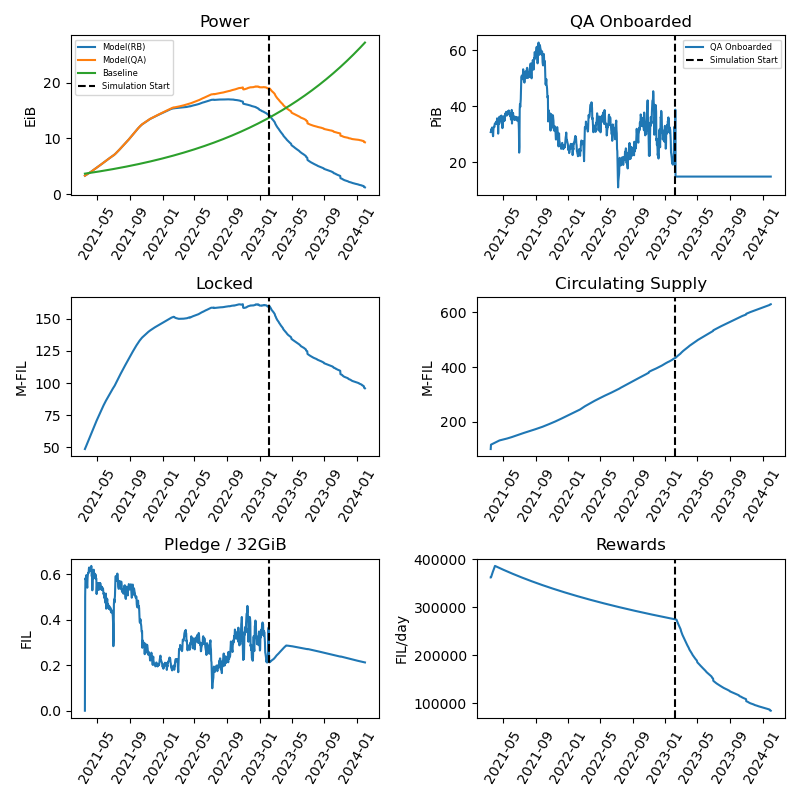

In [9]:
plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plt.plot(model_df['date'], model_df['total_raw_power_eib'], label='Model(RB)')
plt.plot(model_df['date'], model_df['total_qa_power_eib'], label='Model(QA)')
plt.plot(model_df['date'], model_df['network_baseline'] / 2**60, label='Baseline')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.legend(fontsize=6)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('Power')

plt.subplot(3,2,2)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'], label='QA Onboarded')
# plt.plot(model_df['date'], model_df['day_renewed_qap_pib'], label='QA Renewed')
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('QA Onboarded')
plt.ylabel('PiB')
plt.legend(fontsize=6)

plt.subplot(3,2,3)
plt.plot(model_df['date'], model_df['network_locked']/1_000_000)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Locked')

plt.subplot(3,2,4)
plt.plot(model_df['date'], model_df['circ_supply']/1_000_000)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('M-FIL')
plt.xticks(rotation=60)
plt.title('Circulating Supply')

plt.subplot(3,2,5)
plt.plot(model_df['date'], model_df['day_pledge_per_QAP'])
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL')
plt.xticks(rotation=60)
plt.title('Pledge / 32GiB')

plt.subplot(3,2,6)
plt.plot(model_df['date'], model_df['day_network_reward'])
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.ylabel('FIL/day')
plt.xticks(rotation=60)
plt.title('Rewards')


plt.tight_layout()

plt.show()

In [10]:
forecasts_df = filecoin_model.global_forecast_df
update_dates = filecoin_model.minting_process.update_dates

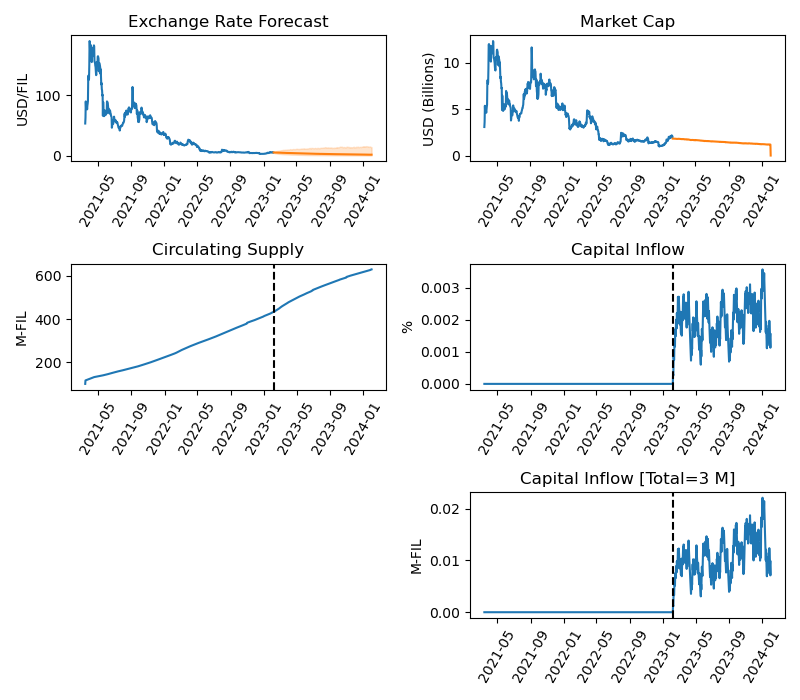

In [11]:
plt.figure(figsize=(8,7))
colors = plt.get_cmap('tab10')

plt.subplot(3,2,1)
fcast_before_sim_start = forecasts_df[pd.to_datetime(forecasts_df['date']) < pd.to_datetime(simulation_start_date)]
fcast_after_sim_start = forecasts_df[(pd.to_datetime(forecasts_df['date']) >= pd.to_datetime(simulation_start_date)) & (pd.to_datetime(forecasts_df['date']) <= pd.to_datetime(end_date))]

plt.plot(fcast_before_sim_start['date'], fcast_before_sim_start['price_Q50'], color=colors(0))
plt.fill_between(fcast_after_sim_start['date'], 
                 fcast_after_sim_start['price_Q05'], fcast_after_sim_start['price_Q95'], alpha=0.2, color=colors(1))
plt.plot(fcast_after_sim_start['date'], fcast_after_sim_start['price_Q50'], color=colors(1))

plt.xticks(rotation=60)
plt.tight_layout()
plt.ylabel('USD/FIL')
plt.title('Exchange Rate Forecast')

plt.subplot(3,2,2)
plt.plot(fcast_before_sim_start['date'], fcast_before_sim_start['market_caps']/1e9)
plt.plot(fcast_after_sim_start['date'], fcast_after_sim_start['market_caps']/1e9)
plt.xticks(rotation=60)
plt.title('Market Cap')
plt.ylabel('USD (Billions)')

plt.subplot(3,2,3)
plt.plot(model_df['date'], model_df['circ_supply']/1e6)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('M-FIL')

plt.subplot(3,2,4)
plt.plot(model_df['date'], model_df['capital_inflow_pct'])
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('Capital Inflow')
plt.ylabel('%')

plt.subplot(3,2,6)
plt.plot(model_df['date'], model_df['capital_inflow_FIL']/1e6)
plt.axvline(x=simulation_start_date, color='k', linestyle='--', label='Simulation Start')
plt.xticks(rotation=60)
plt.title('Capital Inflow [Total=%d M]' % (np.sum(model_df['capital_inflow_FIL'])/1e6))
plt.ylabel('M-FIL')


plt.tight_layout()

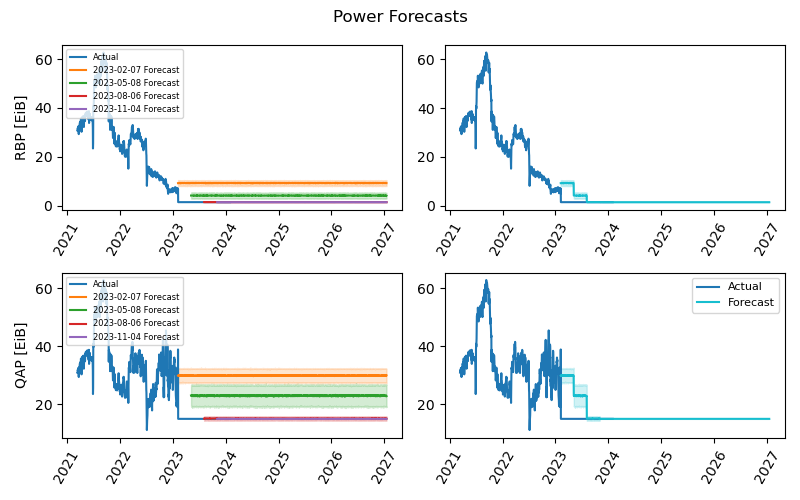

In [12]:
plt.figure(figsize=(8,5))

colors = plt.get_cmap('tab10')

plt.subplot(2,2,1)
plt.plot(model_df['date'], model_df['day_onboarded_rbp_pib'], label='Actual')
for ii, d in enumerate(update_dates):
    date_str = d.strftime('%Y-%m-%d')
    plt.fill_between(forecasts_df['date'], 
                     forecasts_df['rb_onboard_pib_forecast_Q05_%s' % (date_str,)], 
                     forecasts_df['rb_onboard_pib_forecast_Q95_%s' % (date_str,)], 
                     alpha=0.2, color=colors(ii+1))
    plt.plot(forecasts_df['date'], forecasts_df['rb_onboard_pib_forecast_Q50_%s' % (date_str,)], 
             label='%s Forecast' % (date_str,), color=colors(ii+1))
plt.xticks(rotation=60)
plt.legend(fontsize=6, loc='upper left')
plt.ylabel('RBP [EiB]')

plt.subplot(2,2,2)
plt.plot(model_df['date'], model_df['day_onboarded_rbp_pib'], label='Actual')
plt.fill_between(forecasts_df['date'], 
                 forecasts_df['rb_onboard_pib_forecast_Q05'], forecasts_df['rb_onboard_pib_forecast_Q95'], 
                 alpha=0.2, color=colors(9))
plt.plot(forecasts_df['date'], forecasts_df['rb_onboard_pib_forecast_Q50'], label='Forecast', color=colors(9))
plt.xticks(rotation=60)

plt.subplot(2,2,3)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'], label='Actual')
for ii, d in enumerate(update_dates):
    date_str = d.strftime('%Y-%m-%d')
    plt.fill_between(forecasts_df['date'], 
                     forecasts_df['qa_onboard_pib_forecast_Q05_%s' % (date_str,)], 
                     forecasts_df['qa_onboard_pib_forecast_Q95_%s' % (date_str,)], 
                     alpha=0.2, color=colors(ii+1))
    plt.plot(forecasts_df['date'], forecasts_df['qa_onboard_pib_forecast_Q50_%s' % (date_str,)], 
             label='%s Forecast' % (date_str,), color=colors(ii+1))
plt.xticks(rotation=60)
plt.legend(fontsize=6, loc='upper left')
plt.ylabel('QAP [EiB]')

plt.subplot(2,2,4)
plt.plot(model_df['date'], model_df['day_onboarded_qap_pib'], label='Actual')
plt.fill_between(forecasts_df['date'], 
                 forecasts_df['qa_onboard_pib_forecast_Q05'], 
                 forecasts_df['qa_onboard_pib_forecast_Q95'], 
                 alpha=0.2, color=colors(9))
plt.plot(forecasts_df['date'], forecasts_df['qa_onboard_pib_forecast_Q50'], label='Forecast', color=colors(9))
plt.xticks(rotation=60)


plt.suptitle('Power Forecasts')

plt.tight_layout()
plt.legend(fontsize=8)

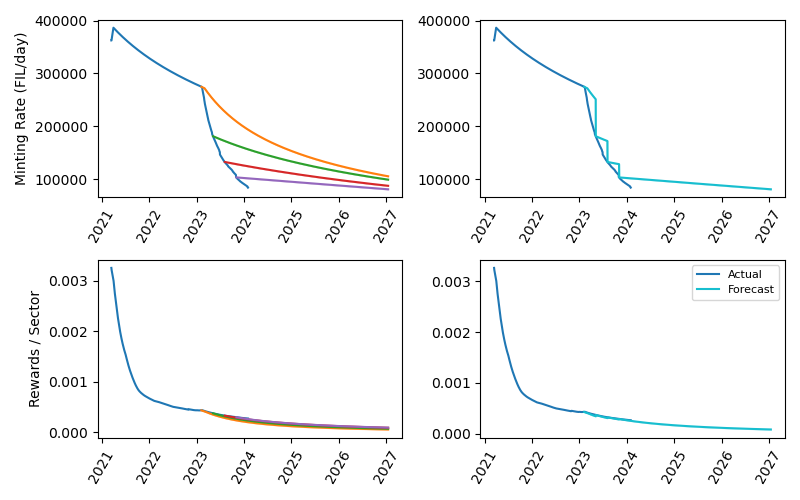

In [13]:
plt.figure(figsize=(8,5))

colors = plt.get_cmap('tab10')

plt.subplot(2,2,1)
plt.plot(model_df['date'], model_df['day_network_reward'], label='Actual')
for ii, d in enumerate(update_dates):
    date_str = d.strftime('%Y-%m-%d')
    plt.fill_between(forecasts_df['date'], 
                     forecasts_df['day_network_reward_forecast_Q05_%s' % (date_str,)], 
                     forecasts_df['day_network_reward_forecast_Q95_%s' % (date_str,)], 
                     alpha=0.2, color=colors(ii+1))
    plt.plot(forecasts_df['date'], forecasts_df['day_network_reward_forecast_Q50_%s' % (date_str,)], 
             label='%s Forecast' % (date_str,), color=colors(ii+1))
plt.xticks(rotation=60)
plt.ylabel('Minting Rate (FIL/day)')

plt.subplot(2,2,2)
plt.plot(model_df['date'], model_df['day_network_reward'], label='Actual')
plt.fill_between(forecasts_df['date'], 
                 forecasts_df['day_network_reward_forecast_Q05'], forecasts_df['day_network_reward_forecast_Q95'], 
                 alpha=0.2, color=colors(9))
plt.plot(forecasts_df['date'], forecasts_df['day_network_reward_forecast_Q50'], label='Forecast', color=colors(9))
plt.xticks(rotation=60)

plt.subplot(2,2,3)
plt.plot(model_df['date'], model_df['day_rewards_per_sector'], label='Actual')
for ii, d in enumerate(update_dates):
    date_str = d.strftime('%Y-%m-%d')
    plt.fill_between(forecasts_df['date'], 
                     forecasts_df['day_rewards_per_sector_forecast_Q05_%s' % (date_str,)], 
                     forecasts_df['day_rewards_per_sector_forecast_Q95_%s' % (date_str,)], 
                     alpha=0.2, color=colors(ii+1))
    plt.plot(forecasts_df['date'], forecasts_df['day_rewards_per_sector_forecast_Q50_%s' % (date_str,)], 
             label='%s Forecast' % (date_str,), color=colors(ii+1))
plt.xticks(rotation=60)
plt.ylabel('Rewards / Sector')

plt.subplot(2,2,4)
plt.plot(model_df['date'], model_df['day_rewards_per_sector'], label='Actual')
plt.fill_between(forecasts_df['date'], 
                 forecasts_df['day_rewards_per_sector_forecast_Q05'], forecasts_df['day_rewards_per_sector_forecast_Q95'], 
                 alpha=0.2, color=colors(9))
plt.plot(forecasts_df['date'], forecasts_df['day_rewards_per_sector_forecast_Q50'], label='Forecast', color=colors(9))
plt.xticks(rotation=60)

plt.tight_layout()
plt.legend(fontsize=8)